## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('AZN-AstraZeneca.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.610001,41.759998,41.480000,41.759998,36.845531,4590000
2019-03-04,41.730000,41.810001,41.389999,41.689999,36.783772,3948200
2019-03-05,41.560001,42.610001,41.560001,42.310001,37.330799,5668200
2019-03-06,42.360001,42.389999,41.930000,42.029999,37.083755,2490000
2019-03-07,41.610001,41.770000,41.330002,41.660000,36.757294,5283900
...,...,...,...,...,...,...
2024-05-24,78.129997,78.889999,78.080002,78.540001,78.540001,3566600
2024-05-28,77.779999,77.820000,76.489998,76.620003,76.620003,4199000
2024-05-29,76.129997,76.510002,75.800003,76.080002,76.080002,4653800


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
32/32 - 77s - 2s/step - loss: 0.0351
Epoch 2/50
32/32 - 6s - 189ms/step - loss: 0.0086
Epoch 3/50
32/32 - 5s - 171ms/step - loss: 0.0074
Epoch 4/50
32/32 - 6s - 178ms/step - loss: 0.0074
Epoch 5/50
32/32 - 5s - 170ms/step - loss: 0.0064
Epoch 6/50
32/32 - 6s - 186ms/step - loss: 0.0067
Epoch 7/50
32/32 - 6s - 173ms/step - loss: 0.0062
Epoch 8/50
32/32 - 7s - 204ms/step - loss: 0.0059
Epoch 9/50
32/32 - 9s - 284ms/step - loss: 0.0058
Epoch 10/50
32/32 - 9s - 281ms/step - loss: 0.0056
Epoch 11/50
32/32 - 7s - 211ms/step - loss: 0.0052
Epoch 12/50
32/32 - 7s - 223ms/step - loss: 0.0052
Epoch 13/50
32/32 - 7s - 220ms/step - loss: 0.0046
Epoch 14/50
32/32 - 8s - 237ms/step - loss: 0.0050
Epoch 15/50
32/32 - 10s - 301ms/step - loss: 0.0050
Epoch 16/50
32/32 - 9s - 271ms/step - loss: 0.0048
Epoch 17/50
32/32 - 8s - 257ms/step - loss: 0.0046
Epoch 18/50
32/32 - 10s - 308ms/step - loss: 0.0040
Epoch 19/50
32/32 - 7s - 234ms/step - loss: 0.0041
Epoch 20/50
32/32 - 8s - 241ms/step - lo

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step


## Calculate the error of the model

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
# Evaluate the accuracy of test

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)


print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  0.019894337058165727
RMSE on Test dataset:  1.7011953263696753
MSLE on Test dataset:  0.0005931730017273121
MAE on Test dataset:  1.3773060551140555


## Predict Close price for 60 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Predict Close price for 60 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_60_days = []

for i in range(60):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_60_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

In [14]:
# Show the result of predict 60 next days 
y_next_60_days = scaler.inverse_transform(np.array(y_next_60_days).reshape(-1, 1))
print(y_next_60_days.flatten())

[74.788216 74.62058  74.20911  73.64557  73.06251  72.53261  72.072716
 71.67341  71.31947  70.997505 70.696724 70.40828  70.1249   69.84115
 69.55357  69.26073  68.96293  68.66172  68.35943  68.05867  67.76194
 67.47143  67.18868  66.9147   66.64986  66.39395  66.14644  65.90643
 65.672935 65.44489  65.221344 65.00142  64.78444  64.569916 64.357544
 64.1471   63.93861  63.73211  63.527695 63.325504 63.125652 62.928238
 62.733345 62.540974 62.351135 62.163788 61.97888  61.796333 61.616055
 61.43795  61.261944 61.08795  60.915894 60.745693 60.577335 60.410797
 60.246017 60.08302  59.92175  59.762188]


## Model visualization

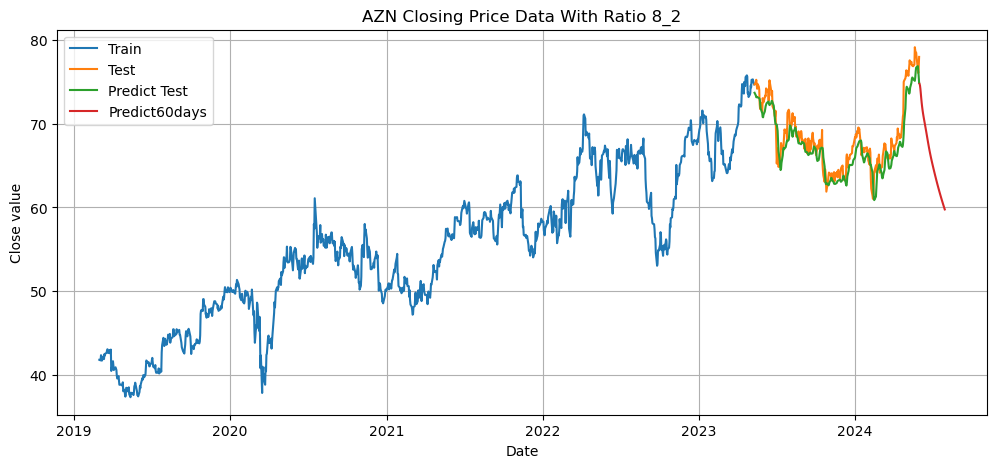

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 60 next days
plt.plot(index_next_60_days, y_next_60_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict60days'])
plt.grid()
plt.title("AZN Closing Price Data With Ratio 8_2")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_82_60days_AZN.png')
plt.show()